# ECG Beat Detector Comparison
## Important Variables
Important variables used throughout the code can be changed here.
- `segmentation_window_size`: every signal in a database is sliced into pieces of `segmentation_window_size` seconds to make the signals more comparable
- `tolerance_window_size`: to determine whether a QRS complex was determined correctly a tolerance window of ±`tolerance_window_size` milliseconds is used
- `print_detector_failure`: to decide whether a print should be shown if a detecor failes

In [46]:
segmentation_window_size = 10 # in seconds, default = 10
tolerance_window_size = 150 # in milliseconds, default = 150
print_detector_failure = 1 # print detector failure, 1 to print them, 0 to not print them, default = 0

## Import Libraries & Start Engines
Install all important libraries with pip apart from `matlab.engine` which has to be installed from the MATLAB root folder. You can find more information on instlaling the `matlab.engine` [here](https://de.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html)

In [47]:
# MATLAB library
import matlab.engine
# general math libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib widget
# other general libraries
import time
import pickle
import os
from os import listdir
from os.path import isfile, join
from itertools import cycle
import pandas
# ecg signal and detector libraries
import wfdb
from wfdb import processing
from ecgdetectors import Detectors
from detectors.visgraphdetector import VisGraphDetector
import neurokit2 as nk
# setting the current working directory
current_working_directory = os.getcwd()

Start the `matlab.engine` to be able to execute MATLAB commands or functions from within Python.

In [48]:
eng = matlab.engine.start_matlab()

## Define Classes and Functions
`Detector` class to store all values necessary for a detector. This can later be added to a list of `detectors`.

In [49]:
class Detector():
    def __init__(self, name, short_name, algorithm) -> None:
        self.name = name
        self.algorithm = algorithm
        self.short_name = short_name
    
    def predicted_qrs_compelx(self, signal, fs):
        return self.algorithm(signal, fs)

    def name(self):
        return self.name

    def short_name(self):
        return self.short_name

An `Evaluation` gets a `RecordingSegment` or `Recording` described below and the functions `predicted_peaks`, `binary_classification`, and `score_calculation`. The function `calculate` returns the whole element including `predicted_peaks`, number of predicted peaks `pp`, true positives `tp`, false positives `fp`, false negatives `fn`, `sensitivity`, `positive_predictivity`, and the `f1_score`.

In [50]:
class Evaluation():
    def __init__(self, RecordingSegment, Detector, predict_peaks, binary_classification, score_calculation) -> None:
        self.RecordingSegment = RecordingSegment
        self.Detector = Detector
        self.predict_peaks = predict_peaks
        self.binary_classification = binary_classification
        self.score_calculation = score_calculation
        self.predicted_peaks = None # predicted peaks as indexes
        self.runtime = 0
        self.pp = self.tp = self.fp = self.fn = None # number of predicted peaks, true positives, false positives, false negatives respectively
        self.sensitivity = self.positive_predictivity = self.f1_score = None
        self.failed = None
    
    def calculate(self):
        self.predicted_peaks, self.runtime, self.failed = self.predict_peaks(self.RecordingSegment,self.Detector)
        self.pp, self.tp, self.fp, self.fn = self.binary_classification(self.RecordingSegment, self.predicted_peaks)
        self.sensitivity, self.positive_predictivity, self.f1_score = self.score_calculation(self.tp, self.fp, self.fn)
        return self

`Database` class to store all values necessary for a databse. This can later be added to a list of `databases`.

In [51]:
class Database():
    def __init__(self, Name, Users, Fs) -> None:
        self.Name = Name
        self.Users = Users
        self.Fs = Fs

    def Name(self):
        return self.Name

    def Users(self):
        return self.Users

    def Fs(self):
        return self.Fs

Each `Database` stores a list of `Users`. This `User` class stores important information about a user and a list to `Recordings` this user took. `User` can here also be used if a database stores arrythmia and sinus rythm signals.

In [52]:
class User():
    def __init__(self, UserName,Recordings) -> None:
        self.UserName = UserName
        self.Recordings = Recordings

    def UserName(self):
        return self.UserName

    def Recordings(self):
        return self.Recordings

Each `User` stores a list of `Recordings`. This `Recording` class stores important information about a recording and a list to `RecordingSegments` created from the signal in `Recording`. `Recording` stores the whole unsplit signal and list of actual QRS complexes. 

In [53]:
class Recording():
    def __init__(self, RecordingName, RecordingSegments, WholeSignal, WholeActual_Qrs_Complex, Fs, AdditionalInfo = None) -> None:
        self.RecordingName = RecordingName
        self.RecordingSegments = RecordingSegments
        self.WholeSignal = WholeSignal
        self.WholeActual_Qrs_Complex = WholeActual_Qrs_Complex
        self.Fs = Fs
        self.Evaluations = []
        self.AdditionalInfo = AdditionalInfo

    def RecordingName(self):
        return self.RecordingName
    
    def RecordingSegments(self):
        return self.RecordingSegments

    def WholeSignal(self):
        return self.WholeSignal
    
    def WholeActual_Qrs_Complex(self):
        return self.WholeActual_Qrs_Complex

    def Fs(self):
        return self.Fs

    def Evaluation(self, detectors, predict_peaks, binary_classification, score_calculation):
        self.Evaluations = []
        for detector in detectors:
            self.Evaluations.append(Evaluation(self,detector,predict_peaks, binary_classification, score_calculation).calculate())
        return self.Evaluations
    
    def addAdditionalInfo(self, AdditionalInfo):
        self.AdditionalInfo = AdditionalInfo

Each `Recording` stores a list of `RecordingSegments`. The `RecordingSegment` class stores important information about a segment of a recording. The function `Evaluation` which takes a list of `detectors` and three functions as an input returns a list of `Evaluation` objects, one for each detector.

In [54]:
class RecordingSegment():
    def __init__(self, Signal, Actual_Qrs_Complex, Fs, AdditionalInfo = None) -> None:
        self.Signal = Signal
        self.Actual_Qrs_Complex = Actual_Qrs_Complex
        self.Fs = Fs
        self.Evaluations = []
        self.AdditionalInfo = AdditionalInfo

    def Signal(self):
        return self.Signal

    def Actual_Qrs_Complex(self):
        return self.Actual_Qrs_Complex

    def Fs(self):
        return self.Fs

    def Evaluation(self, detectors, predict_peaks, binary_classification, score_calculation):
        self.Evaluations = []
        for detector in detectors:
            self.Evaluations.append(Evaluation(self,detector,predict_peaks, binary_classification, score_calculation).calculate())
        return self.Evaluations

    def addAdditionalInfo(self, AdditionalInfo):
        self.AdditionalInfo = AdditionalInfo

This is a function to split signals in smaller parts including the respecitve qrs complexes. `split_signal` returns an array of arrays where the inner arrays store the signals and the qrs complexes and the outer array stores the inner arrays.

In [55]:
def split_signal(signal, fs, actual_qrs_complexes):
    signal = np.array(signal)
    actual_qrs_complexes = np.array(actual_qrs_complexes)
    split = [[] for i in range(((len(signal)//(fs*segmentation_window_size)*2)-1))]

    for split_signal_counter in range((len(signal)//(fs*segmentation_window_size)*2)-1):
        min_index = split_signal_counter*(fs*segmentation_window_size//2)
        max_index = split_signal_counter*(fs*segmentation_window_size//2)+fs*segmentation_window_size-1

        split[split_signal_counter].append(signal[min_index:max_index])

        min_counter = 0
        max_counter = 0

        for qrs_complex_counter in range(len(actual_qrs_complexes)):
            if actual_qrs_complexes[qrs_complex_counter] < min_index:
                min_counter += 1
            if actual_qrs_complexes[qrs_complex_counter] < max_index:
                max_counter += 1
        split[split_signal_counter].append(actual_qrs_complexes[min_counter:max_counter]-min_index)

    return split


## Create Database Objects
### Telehealth Database
Create a `Database` object for `telehealth_environment_database` including all sub objects necessary to initialize it.

In [56]:
path = join(current_working_directory,'databases/telehealth')
files = [f for f in listdir(path) if isfile(join(path, f))]

fs = 500
users = []
recordings = []
for file in files:
    recordingsegments = []
    data = pandas.read_csv(join(path, file),sep=",",header=None)
    signal = np.array(data[0]).astype(float)
    qrs_complex_indices = np.array(data[1]).astype(int)
    actual_qrs_complexes = []
    
    for indexcounter in range(len(qrs_complex_indices)):
        if qrs_complex_indices[indexcounter]:
            actual_qrs_complexes.append(indexcounter)
    
    splits = split_signal(signal=signal,fs=fs, actual_qrs_complexes=np.array(actual_qrs_complexes).astype(int))
    
    for split in splits:
        recordingsegments.append(RecordingSegment(Signal=split[0], Actual_Qrs_Complex=split[1], Fs=fs))
    recordings.append(Recording(RecordingName=str(file),RecordingSegments = recordingsegments,WholeSignal=signal,WholeActual_Qrs_Complex=actual_qrs_complexes,Fs=fs))
users.append(User(UserName="default",Recordings = recordings))   
        
telehealth_environment_database = Database(
    Name="Telehealth Test Database",
    Users=users,
    Fs=fs)

### Synthetic Database
Some initial parameters for the generation of the synthetic signals. Here it is possible to choose diffent types of artificial noise and also choose whether the signal should be real or synthetic.

In [57]:
# ---Initial parameters---
rrLength = 50       # A desired ECG signal length (the number of RR intervals) 
APBrate = 0.10      # Rate of atrial premature beats (APB). A number between 0 and 0.5
onlyRR = 0          # 1 - only RR intervals are generated, 0 - multilead ECG is generated

medEpis = 15        # Median duration of an atrial fibrillation (AF) episode
stayInAF = float(1-np.log(2)/medEpis)   # Probability to stay in AF state
AFburden = 0.8      # AF burden. 0 - the entire signal is sinus rhythm (SR), 1 - the entire signal is AF

noiseType = 4       # Type of noise. A number from 0 to 4. 0 - no noise added (noise RMS = 0 mV), 
                    # 1 - motion artefacts, 2 - electrode movement artefacts, 3 - baseline wander, 
                    # 4 - mixture of type 1, type 2 and type 3 noises
noiseRMS = 0.02     # Noise level in milivolts 

realRRon = 1        # 1 - real RR series are used, 0 - synthetic
realVAon = 1        # 1 - real ventricular activity is used, 0 - synthetic
realAAon = 1        # 1 - real atrial activity is used, 0 - synthetic
# Note: cannot select real atrial activity and synthetic ventricular activity

Generate a synthetic signal and safe it in `returndata`

In [58]:
path = eng.genpath('C:/Users/flori\OneDrive\Dokumente\TU\Bachelor Thesis\Code\Signal_generator')
eng.addpath(path, nargout=0)

data = eng.simPAF_ECG_generator(rrLength, realRRon, realVAon, realAAon, AFburden, stayInAF, APBrate, noiseType, noiseRMS, onlyRR)

Create a `Database` object for `synth_database` including all sub objects necessary to initialize it.

In [59]:
fs = 500
signal = np.transpose(np.array(data['multileadECG']))[:,0]
actual_qrs_complexes = np.transpose(np.array(data['QRSindex']))[:,0].astype(int)

splits = split_signal(signal=signal,fs=fs,actual_qrs_complexes=actual_qrs_complexes)

recordingsegments = []
for split in splits:
    recordingsegments.append(RecordingSegment(Signal=split[0],Actual_Qrs_Complex=split[1],Fs=fs))
recordings = [Recording("default",RecordingSegments=recordingsegments, WholeSignal=signal,WholeActual_Qrs_Complex=actual_qrs_complexes,Fs=fs)]
users = [User(UserName="default",Recordings=recordings)]

synth_database = Database(
    Name="Synthetic data", 
    Users=users,
    Fs=fs)

### WFDB Test Database
Create a `Database` object for `wfdb_test_database` including all sub objects necessary to initialize it.

In [60]:
fs = wfdb.rdrecord('sample-data/100', sampfrom=0, sampto=10000, channels=[0]).fs
signal = np.array(wfdb.rdrecord('sample-data/100', sampfrom=0, sampto=10000, channels=[0]).p_signal[:,0])
actual_qrs_complexes = np.array(wfdb.rdann('sample-data/100','atr', sampfrom=0, sampto=10000).sample[1:]).astype(int)

splits = split_signal(signal=signal, fs=fs, actual_qrs_complexes=actual_qrs_complexes)

recordingsegments = []
for split in splits:
    recordingsegments.append(RecordingSegment(Signal=split[0],Actual_Qrs_Complex=split[1],Fs=fs))
recordings = [Recording("default",RecordingSegments=recordingsegments, WholeSignal=signal,WholeActual_Qrs_Complex=actual_qrs_complexes,Fs=fs)]
users = [User(UserName="default",Recordings=recordings)]

wfdb_test_database = Database(
    Name="WFDB Test Database",
    Users=users,
    Fs=fs)

### MIT-BIH Arrhythmia Database
Create a `Database` object for `mit_bih_arrhythmia_database` including all sub objects necessary to initialize it.

In [61]:
path = "C:/Users/flori\OneDrive\Dokumente\TU\Bachelor Thesis\Code\TestDatabases\mit-bih-arrhythmia-database-1.0.0"
files = np.array(pandas.read_csv(join(path, "RECORDS"),header=None)[0])

fs = wfdb.rdrecord(join(path,str(files[0])), channels=[0]).fs

users = []

for file in files:
    recordings = []
    recordingsegments = []
    signal = np.array(wfdb.rdrecord(join(path,str(file)), channels=[0]).p_signal[:,0]).astype(float)
    actual_qrs_complexes = np.array(wfdb.rdann(join(path,str(file)),'atr').sample[1:]).astype(int)
    
    splits = split_signal(signal=signal,fs=fs, actual_qrs_complexes=actual_qrs_complexes)
    
    for split in splits:
        recordingsegments.append(RecordingSegment(Signal=split[0], Actual_Qrs_Complex=split[1], Fs=fs))
    recordings.append(Recording(RecordingName="default",RecordingSegments = recordingsegments,WholeSignal=signal,WholeActual_Qrs_Complex=actual_qrs_complexes,Fs=fs))
    users.append(User(UserName=str(file),Recordings = recordings))

mit_bih_arrhythmia_database = Database(
    Name="MIT-BIH Arrhythmia Database",
    Users=users,
    Fs=fs)

## Create Detector Objects
Create `Detector` objects for detectors from different locations in the standaradized format.

Create `gqrs_detector` object. This detector stems from the wfdb toolbox. More information can be found online.

In [62]:
gqrs_detector = Detector(name="GQRS", short_name="gqrs", algorithm=processing.qrs.gqrs_detect)

Create `jqrs_detector` object. This detector is written in MATLAB and also executed via the MATLAB engine. Therefore a function has been written to get it into the right format. More information can be found in the respective file.

In [63]:
path = eng.genpath(join(current_working_directory,'detectors\jqrs'))
eng.addpath(path, nargout=0)

def run_jqrs_detector(signal, fs):
    threshold = 0.6 # energy threshold of the detector in au, default = 0.6
    ref_period = 0.250 # refractory period in sec between two R-peaks in ms, default = 0.250
    newsignal = [[i] for i in signal]
    return np.array(eng.qrs_detect2(matlab.double(newsignal), threshold, ref_period, matlab.double(fs)))[0].astype(int)

jqrs_detector = Detector(name="JQRS", short_name="jqrs", algorithm=run_jqrs_detector)

Create `visgraph_detector` object. For this detector a Python implementation is used. More information can be found in the respecitve file.

In [64]:
def run_visgraph_detector(signal, fs):
    beta = 0.55 # beta, default = 0.55
    gamma = 0.5 # gamm, default = 0.5
    lowcut = 4 # lowcut, default = 4
    R_peaks, weights, weighted_signal = VisGraphDetector(fs).visgraphdetect(signal, beta=beta, gamma=gamma, lowcut=lowcut, M = 2*fs)
    return R_peaks

visgraph_detector = Detector(name="VisGraphDetector", short_name="visgraph", algorithm=run_visgraph_detector)

Create `rpeakdetect_detector` object. This detector is written in MATLAB and also executed via the MATLAB engine. Therefore a function has been written to get it into the right format. More information can be found in the respective file.

In [65]:
path = eng.genpath(join(current_working_directory,'detectors'))
eng.addpath(path, nargout=0)

def run_rpeakdetect_detector(signal, fs):
    threshhold = 0.2 # default = 0.2
    testmode = 0 # default = 0
    newsignal = [[i] for i in signal]
    return np.array(eng.rpeakdetect(matlab.double(newsignal), matlab.double(fs),threshhold,testmode)['R_index'])[0].astype(int)

rpeakdetect_detector = Detector(name="rpeakdetect", short_name="rpeak", algorithm=run_rpeakdetect_detector)

Create `r_deco_detector` object. This detector is written in MATLAB and also executed via the MATLAB engine. Therefore a function has been written to get it into the right format. More information can be found in the respective file.

In [66]:
path = eng.genpath(join(current_working_directory,'detectors/r_deco'))
eng.addpath(path, nargout=0)

def run_r_deco_detector(signal, fs):
    envelope_size = 300.0 # envelope size in ms, default = 300.0
    average_heart_rate = 100.0 # average heart rate in bpm, default = 100.0
    post_processing = 1.0 # post processing where 1.0 means yes, default = 1.0
    ectopic_removal = 0.0 # ectopic removal where 1.0 means yes, default = 0.0
    inverted_signal = 0.0 # inverted signal where 1.0 means yes, default = 0.0
    parameters_check = 0.0 # parameters check in UI where 1.0 means yes, default = 0.0
    newsignal = [[i] for i in signal]
    return np.array(eng.peak_detection([envelope_size,average_heart_rate,post_processing,ectopic_removal,inverted_signal],matlab.double(newsignal), matlab.double(fs),parameters_check)).astype(int)[0][0]

r_deco_detector = Detector(name="r_deco", short_name="rdeco", algorithm=run_r_deco_detector)

Create `unsw_detector` object. This detector is written in MATLAB and also executed via the MATLAB engine. Therefore a function has been written to get it into the right format. More information can be found in the respective file.

In [67]:
path = eng.genpath(join(current_working_directory,'detectors/unsw'))
eng.addpath(path, nargout=0)

def run_unsw_detector(signal, fs):
    mask = [] # mask could be implemented later if wanted
    plotting = False # 1.0 for ploting intermediate signals, 0.0 for no plotting, default = 0.0
    newsignal = [[i] for i in signal]
    return np.array(eng.UNSW_QRSDetector(matlab.double(newsignal), matlab.double(fs),matlab.double(mask),bool(plotting))).astype(int)[0] #,matlab.double(mask),plotting)

unsw_detector = Detector(name="UNSW_QRSDetector", short_name="unsw", algorithm=run_unsw_detector)

Create functions to get the detectors from the `ecgdetectors` package into the right standard format. Additionally they are safed into their own objects. More information about the package can be found online.

In [68]:
def run_two_average_detector(signal, fs):
    return Detectors(fs).two_average_detector(unfiltered_ecg=signal)

two_average_detector = Detector(name="Elgendi et al (Two average)", short_name="two_avg", algorithm=run_two_average_detector)

def run_matched_filter_detector(signal, fs):
    return Detectors(fs).matched_filter_detector(unfiltered_ecg=signal)

matched_filter_detector = Detector(name="Matched filter", short_name="match_fil", algorithm=run_matched_filter_detector)

def run_swt_detector(signal, fs):
    return Detectors(fs).swt_detector(unfiltered_ecg=signal)

swt_detector = Detector(name="Kalidas & Tamil (Wavelet transform)", short_name="swt", algorithm=run_swt_detector)

def run_engzee_detector(signal, fs):
    return Detectors(fs).engzee_detector(unfiltered_ecg=signal)

engzee_detector = Detector(name="Engzee", short_name="engz", algorithm=run_engzee_detector)

def run_christov_detector(signal, fs):
    return Detectors(fs).christov_detector(unfiltered_ecg=signal)

christov_detector = Detector(name="Christov", short_name="christ", algorithm=run_christov_detector)

def run_hamilton_detector(signal, fs):
    return Detectors(fs).hamilton_detector(unfiltered_ecg=signal)

hamilton_detector = Detector(name="Hamilton", short_name="hamilt", algorithm=run_hamilton_detector)

def run_pan_tompkins_detector(signal, fs):
    return Detectors(fs).pan_tompkins_detector(unfiltered_ecg=signal)

pan_tompkins_detector = Detector(name="Pan Tompkins", short_name="pan_tomp", algorithm=run_pan_tompkins_detector)

def run_wqrs_detector(signal, fs):
    return Detectors(fs).wqrs_detector(unfiltered_ecg=signal)

wqrs_detector = Detector(name="WQRS", short_name="wqrs", algorithm=run_wqrs_detector)

Create functions to get the detectors from the `neurokit2` package into the right standard format. Additionally they are safed into their own objects. More information about the package can be found online.

In [69]:
def run_neurokit(signal, fs):
    # neurokit (default)
    cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="neurokit")
    _, neurokit = nk.ecg_peaks(cleaned, sampling_rate=fs, method="neurokit")
    return neurokit["ECG_R_Peaks"]

neurokit_detector = Detector(name="neurokit", short_name="nk", algorithm=run_neurokit)

def run_pantompkins1985(signal, fs):
    # pantompkins1985
    cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="pantompkins1985")
    _, pantompkins1985 = nk.ecg_peaks(cleaned, sampling_rate=fs, method="pantompkins1985")
    return pantompkins1985["ECG_R_Peaks"]

pantompkins1985_detector = Detector(name="pantompkins1985", short_name="pan_tomp_nk", algorithm=run_pantompkins1985)

def run_nabian2018(signal, fs):
    # nabian2018
    _, nabian2018 = nk.ecg_peaks(signal, sampling_rate=fs, method="nabian2018")
    return nabian2018["ECG_R_Peaks"]

nabian2018_detector = Detector(name="nabian2018", short_name="nab_nk", algorithm=run_nabian2018)

def run_hamilton2002(signal, fs):
    # hamilton2002
    cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="hamilton2002")
    _, hamilton2002 = nk.ecg_peaks(cleaned, sampling_rate=fs, method="hamilton2002")
    return hamilton2002["ECG_R_Peaks"]

hamilton2002_detector = Detector(name="hamilton2002", short_name="ham_nk", algorithm=run_hamilton2002)

def run_martinez2003(signal, fs):
    # martinez2003
    _, martinez2003 = nk.ecg_peaks(signal, sampling_rate=fs, method="martinez2003")
    return martinez2003["ECG_R_Peaks"]

martinez2003_detector = Detector(name="martinez2003", short_name="mart_nk", algorithm=run_martinez2003)

def run_zong2003(signal, fs):
    # zong2003
    _, zong2003 = nk.ecg_peaks(signal, sampling_rate=fs, method="zong2003")
    return zong2003["ECG_R_Peaks"]

zong2003_detector = Detector(name="zong2003", short_name="zong_nk", algorithm=run_zong2003)

def run_christov2004(signal, fs):
    # christov2004
    _, christov2004 = nk.ecg_peaks(signal, sampling_rate=fs, method="christov2004")
    return christov2004["ECG_R_Peaks"]

christov2004_detector = Detector(name="christov2004", short_name="chris_nk", algorithm=run_christov2004)

def run_gamboa2008(signal, fs):
    # gamboa2008
    cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="gamboa2008")
    _, gamboa2008 = nk.ecg_peaks(cleaned, sampling_rate=fs, method="gamboa2008")
    return gamboa2008["ECG_R_Peaks"]

gamboa2008_detector = Detector(name="gamboa2008", short_name="gamb_nk", algorithm=run_gamboa2008)

def run_elgendi2010(signal, fs):
    # elgendi2010
    cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="elgendi2010")
    _, elgendi2010 = nk.ecg_peaks(cleaned, sampling_rate=fs, method="elgendi2010")
    return elgendi2010["ECG_R_Peaks"]

elgendi2010_detector = Detector(name="elgendi2010", short_name="elg_nk", algorithm=run_elgendi2010)

def run_engzeemod2012(signal, fs):
    # engzeemod2012
    cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="engzeemod2012")
    _, engzeemod2012 = nk.ecg_peaks(cleaned, sampling_rate=fs, method="engzeemod2012")
    return engzeemod2012["ECG_R_Peaks"]

engzeemod2012_detector = Detector(name="engzeemod2012", short_name="engz_nk", algorithm=run_engzeemod2012)

def run_kalidas2017(signal, fs):
    # kalidas2017
    cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="kalidas2017")
    _, kalidas2017 = nk.ecg_peaks(cleaned, sampling_rate=fs, method="kalidas2017")
    return kalidas2017["ECG_R_Peaks"]

kalidas2017_detector = Detector(name="kalidas2017", short_name="kali_nk", algorithm=run_kalidas2017)

def run_rodrigues2021(signal, fs):
    # rodrigues2021
    _, rodrigues2021 = nk.ecg_peaks(signal, sampling_rate=fs, method="rodrigues2021")
    return rodrigues2021["ECG_R_Peaks"]

rodrigues2021_detector = Detector(name="rodrigues2021", short_name="rodr_nk", algorithm=run_rodrigues2021)

## Calculation functions
The function `predict_peaks` predicts peaks in a signal. It needs a segment which can either be a `RecordingSegment` or a `Recording` and a `Detector` as an input. The output is a vector of predicted peaks.

In [70]:
def predict_peaks(segment, detector):
    failed = False

    if isinstance(segment, RecordingSegment):
        signal = segment.Signal
        fs = segment.Fs

    elif isinstance(segment, Recording):
        signal = segment.WholeSignal
        fs = segment.Fs

    else:
        raise Exception('You have to input either a RecordingSegment or a Recording as the segment.')
        
    
    if detector.short_name == "match_fil" and (fs != 250 and fs != 360):
        if print_detector_failure:
            failed = True
            print(detector.short_name, "could not run because the sample rate is wrong and was skipped")
        return [], 0, failed

    #predicted_peaks = detector.predicted_qrs_compelx(signal=signal, fs=fs)
    start = time.time()
    try:
        predicted_peaks = detector.predicted_qrs_compelx(signal=signal, fs=fs)
    except IndexError:
        if print_detector_failure:
            failed = True
            print(detector.short_name, "failed due to an index error and was skipped")
        return [], 0, failed
    except matlab.engine.MatlabExecutionError:
        if print_detector_failure:
            failed = True
            print(detector.short_name, "failed due to a MatlabExecutionError, most likely the signal quality was to bad")
        return [], 0, failed
    runtime = time.time() - start
    return predicted_peaks, runtime, failed

The function `binary_classification` classifies whether the predicted peaks are true-positive, false-positive, and false-negative. It needs a segment which can either be a `RecordingSegment` or a `Recording` and a vector of `predicted_peaks` as an input. The output is the number of predicted peaks `pp`, the number of true-positive peaks `tp`, the number of false-positive peaks `fp`, and the number of false-negative peaks `fn`.

In [71]:
def binary_classification(segment, predicted_peaks):

    if isinstance(segment, RecordingSegment):
        actual_peaks = segment.Actual_Qrs_Complex

    elif isinstance(segment, Recording):
        actual_peaks = segment.WholeActual_Qrs_Complex

    else:
        raise Exception('You have to input either a RecordingSegment or a Recording as the segment.')

    pp = len(predicted_peaks)
    tp = 0
    fp = 0
    fn = 0
    
    actual_peaks_iter = actual_peaks

    for predicted_peak in predicted_peaks:
        tpdetect = 1
        for i in range(len(actual_peaks_iter)):
            if predicted_peak >= (actual_peaks_iter[i] - tolerance_window_size) and predicted_peak <= (actual_peaks_iter[i] + tolerance_window_size):
                tp+=1
                tpdetect = 0
                actual_peaks_iter = np.delete(actual_peaks_iter, i)
                break
        if tpdetect:
            fp+=1

    for actualpeak in actual_peaks_iter:
        fn+=1

    return pp, tp, fp, fn

In [72]:
def score_calculation(tp, fp, fn):
    try:
        sensitivity = tp / (tp+fn)
    except ZeroDivisionError:
        sensitivity = 0
    try:
        positive_predictivity = tp / (tp+fp)
    except ZeroDivisionError:
        positive_predictivity = 0
    try:    
        f1_score = tp / (tp+.5*(fp+fn))
    except ZeroDivisionError:
        f1_score = 0
    return sensitivity, positive_predictivity, f1_score

## Add Databases and Detectors
Create arrays to safe the `detectors` and `databases`.

In [73]:
databases = []
detectors = []

Add data from different databases to `databases`. By commenting or uncommenting a database here, you can decide whether it should be used in the code.

In [74]:
#databases.append(synth_database)
databases.append(wfdb_test_database)
#databases.append(telehealth_environment_database)
#databases.append(mit_bih_arrhythmia_database)

Add detectors to the `detectors`. By commenting or uncommenting a detector here, you can decide whether it should be used in the code.

In [75]:

detectors.append(gqrs_detector)
detectors.append(jqrs_detector)
# detectors.append(visgraph_detector) # takes a lot of time, not used because it takes long and does not give good results
detectors.append(rpeakdetect_detector)
detectors.append(r_deco_detector)
detectors.append(unsw_detector)
# detectors.append(matched_filter_detector) # in ecg-detectors package but not used in neurkit, might be to useless because of frequencies, not used because of frequency issue

detectors.append(wqrs_detector) # differnt implementation of neurokit zong implementation, used because it works, rather slow though
# detectors.append(zong2003_detector) # neurokit detector, different from wqrs, does not work, not used because implementation does not work

# detectors.append(swt_detector) # same es neurokit kalidas implementation but a bit slower even though both refer to the ecg-detectors package, not used because neurokit implementation is faster
detectors.append(kalidas2017_detector) # neurokit detector, same as swt, changed implementation slightly from ecg-detectors package

detectors.append(two_average_detector) # same es neurokit elgendi implementation but a bit faster even though both refer to the ecg-detectors package
# detectors.append(elgendi2010_detector) # neurokit detector, same as two_average, not used because base implementation is faster

detectors.append(engzee_detector) # same es neurokit engzee implementation but a bit faster even though both refer to the ecg-detectors package
# detectors.append(engzeemod2012_detector) # neurokit detector, same as engzee, not used because base implementation is faster

detectors.append(christov_detector) # same es neurokit christov implementation but a bit faster even though both refer to the ecg-detectors package
# detectors.append(christov2004_detector) # neurokit detector, not used because base implementation is faster

detectors.append(hamilton_detector) # same es neurokit hamilton implementation but a bit faster even though both refer to the ecg-detectors package
# detectors.append(hamilton2002_detector) # neurokit detector, same as hamilton, not used because base implementation is faster 

# detectors.append(pan_tompkins_detector) # same as neurokit pan_tompkins implementation but slower even though both refer to the ecg-detectors package, not used because neurokit implementation is faster
detectors.append(pantompkins1985_detector) # neurokit detector, same as pan_tompkins

detectors.append(neurokit_detector) # neurokit detector, new
detectors.append(nabian2018_detector) # neurokit detector, new
detectors.append(martinez2003_detector) # neurokit detector, new
detectors.append(gamboa2008_detector) # neurokit detector, new
# detectors.append(rodrigues2021_detector) # neurokit detector, fails often and does not give the best results if it works

## Predict QRS Complexes
All algorithms are run and the resulting QRS complexes are saved in vectors.

Database:  WFDB Test Database
User:  default
Recording:  default
             gqrs  jqrs  rpeak  rdeco  unsw  wqrs  kali_nk  two_avg  engz  \
runtime (s)  0.06  0.16   0.05   0.13  0.89  0.08     0.00     0.00  0.03   
sensitiv     0.85  1.00   1.00   0.92  1.00  1.00     0.92     0.85  0.85   
pos pred     1.00  1.00   1.00   1.00  1.00  0.93     0.92     1.00  1.00   
f1 score     0.92  1.00   1.00   0.96  1.00  0.96     0.96     0.92  0.92   

             christ  hamilt  pan_tomp_nk    nk  nab_nk  mart_nk  gamb_nk  
runtime (s)    0.07    0.01         0.00  0.00    0.01     0.00     0.01  
sensitiv       0.92    1.00         1.00  0.92    0.85     0.92     1.00  
pos pred       0.92    0.86         0.92  1.00    1.00     1.00     0.40  
f1 score       0.96    0.92         0.96  0.96    0.92     0.96     0.57  


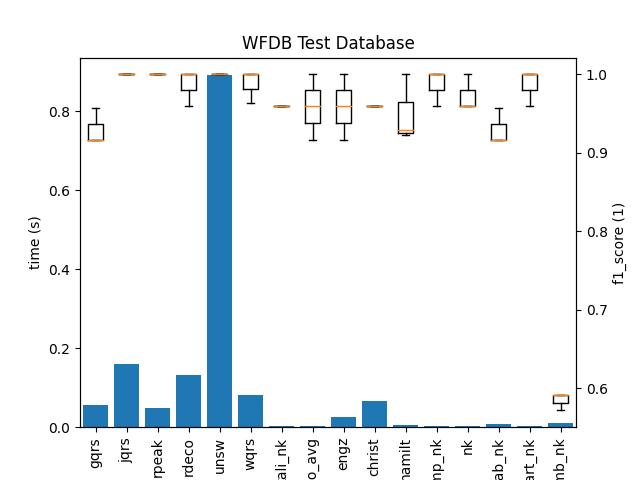

In [76]:
for database in databases:
    print('Database: ',database.Name)
    runtime = [[] for i in range(len(detectors))]
    sensitivity = [[] for i in range(len(detectors))]
    positive_predictivity = [[] for i in range(len(detectors))]
    f1_score = [[] for i in range(len(detectors))]
    for user in database.Users:
        print('User: ',user.UserName)
        for recording in user.Recordings:
            print('Recording: ',recording.RecordingName)
            for recordingsegment in recording.RecordingSegments:
                evaluations = recordingsegment.Evaluation(detectors, predict_peaks, binary_classification, score_calculation)
                for i in range(len(evaluations)):
                    runtime[i].append(evaluations[i].runtime)
                    sensitivity[i].append(evaluations[i].sensitivity)
                    positive_predictivity[i].append(evaluations[i].positive_predictivity)
                    f1_score[i].append(evaluations[i].f1_score)

    data = [np.around([np.mean(time) for time in runtime],decimals=2),np.around([np.min(sens) for sens in sensitivity],decimals=2), np.around([np.min(pos_pred) for pos_pred in positive_predictivity],decimals=2),np.around([np.min(f1) for f1 in f1_score],decimals=2)]
    rows = ["runtime (s)","sensitiv", "pos pred", "f1 score"]
    columns = [detector.short_name for detector in detectors]

    print(pandas.DataFrame(data, rows, columns))

    fig, ax = plt.subplots()
    ax.bar(range(1, len(runtime)+1),[np.mean(time) for time in runtime])
    ax.set_ylabel("time (s)")
    ax2 = ax.twinx()
    ax2.boxplot(f1_score)
    ax2.set_ylabel("f1_score (1)")
    ax.set_xticklabels(columns, rotation = 'vertical')
    ax.set_title(database.Name) 
    ax.set_xlabel("detectors")
      

In [77]:
name = databases[0].Name
recording = databases[0].Users[0].Recordings[0]
signal = recording.WholeSignal
actual_qrs_complexes = recording.WholeActual_Qrs_Complex
evaluations = recording.Evaluation(detectors, predict_peaks, binary_classification, score_calculation)

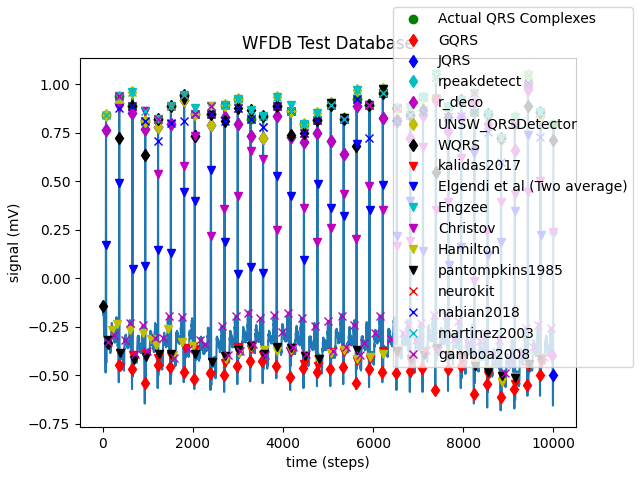

In [78]:
markers = ["d", "v", "x", "+", "*", "^", "<", ">", "1", "2", "3", "4", "8", "s","p", "P", "h", "H", "X", "D", "|", "_", ".", "o"]
colors = ["r", "b", "c", "m", "y", "k"]

fmt = [marker + color for marker in markers for color in colors]

#fmt = ['bo','r<','c^','m>','yv','rx','kd','cp','cx','b>','yx','mx','bx', 'rd', 'r0']
fig, ax = plt.subplots(1)
ax.plot(signal)
ax.plot(actual_qrs_complexes, signal[actual_qrs_complexes], 'go', label = "Actual QRS Complexes")
for i in range(len(evaluations)):
    ax.plot(evaluations[i].predicted_peaks, signal[evaluations[i].predicted_peaks], fmt[i],label=evaluations[i].Detector.name)
ax.set_title(name)
ax.set_xlabel("time (steps)")
ax.set_ylabel("signal (mV)")

fig.legend()

# Experiment 1 - Performance on synthetic data
## Variable declaration
Important variables are declared and changed here.

In [79]:
generate_dataset = False # simulate synthetic dataset, True to simulate, False to skip simulation, default = Flase, simulation takes long
evaluate_dataset = False

## Signal generator
Synthetic signals are generated using the different parameters defined in the next cell. If `generate_dataset` is False the simulation is skipped.

In [80]:
if generate_dataset:
    path = eng.genpath('C:/Users/flori\OneDrive\Dokumente\TU\Bachelor Thesis\Code\Signal_generator')
    eng.addpath(path)


    rrLength = [40]        # A desired ECG signal length (the number of RR intervals) 
    APBrate = [0]      # Rate of atrial premature beats (APB). A number between 0 and 0.5
    onlyRR = [0]          # 1 - only RR intervals are generated, 0 - multilead ECG is generated

    medEpis = [15]        # Median duration of an atrial fibrillation (AF) episode
    stayInAF = 1-np.log(2)/medEpis   # Probability to stay in AF state
    AFburden = [0, 1]      # AF burden. 0 - the entire signal is sinus rhythm (SR), 1 - the entire signal is AF

    noiseType = [0, 1, 2, 3]       # Type of noise. A number from 0 to 4. 0 - no noise added (noise RMS = 0 mV), 
                                # 1 - motion artefacts, 2 - electrode movement artefacts, 3 - baseline wander, 
                                # 4 - mixture of type 1, type 2 and type 3 noises
    noiseRMS = [0.0, 0.5]     # Noise level in milivolts 

    realRRon = [1]        # 1 - real RR series are used, 0 - synthetic
    realVAon = [1]       # 1 - real ventricular activity is used, 0 - synthetic
    realAAon = [1]        # 1 - real atrial activity is used, 0 - synthetic

    repeats = 50

    data = eng.Adapted_simPAF_ECG_generator_iterator(matlab.double(rrLength),matlab.double(APBrate),matlab.double(onlyRR),matlab.double(medEpis),matlab.double(stayInAF),matlab.double(AFburden),matlab.double(noiseType),matlab.double(noiseRMS),matlab.double(realRRon),matlab.double(realVAon),matlab.double(realAAon), matlab.double(repeats))

The cell calculates how many signals already existed before and saves this in `lastwritten`, to be able to add upon existing signals instead of creating the whole database from scratch every time.

In [81]:
if generate_dataset:
    path = join(current_working_directory,'databases/synth')
    files = [f for f in listdir(path) if isfile(join(path, f))]
    lastwritten = 0
    lastwritten = int(files[-1][3:6])
    print(lastwritten)

All signals are saved to the harddrive in the **wfdb format**. This format was choosen as it is common for datasets and the resulting dataset can therefore be shared easily. All information created by the signal generator are saved as comments to make the dataset easily available. While only one lead is used for the experiments here, all of them are saved in the database.

In [82]:
if generate_dataset:
    sig_name = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'X', 'Y', 'Z']
    path = join(current_working_directory,'databases/synth')
    fs = 500

    for j in range(repeats):
        for i  in range(len(data)//repeats):
            synthetic_signal = data['s'+str(j+1)+'c'+str(i+1)]
            signal = np.transpose(np.array(synthetic_signal['multileadECG']))[0:30*fs]
            actual_qrs_complexes = np.transpose(np.array(synthetic_signal['QRSindex'])).astype(int)
            actual_qrs_complexes = np.array([qrs for qrs in actual_qrs_complexes if qrs < (30*fs-1)])
            
            rrLength = synthetic_signal['ip_rrLength']
            APBrate = synthetic_signal['ip_APBrate']
            stayInAF = synthetic_signal['ip_stayInAF']
            AFburden = synthetic_signal['ip_AFburden']
            noiseType = synthetic_signal['ip_noiseType']
            noiseRMS = synthetic_signal['ip_noiseRMS']
            realRRon = synthetic_signal['ip_realRRon']
            realVAon = synthetic_signal['ip_realVAon']
            realAAon = synthetic_signal['ip_realAAon']

            record_name = 'Rep'+str(format(j+lastwritten+1,'03d'))+'_AF' + str(int(AFburden)) + '_nT' + str(int(noiseType)) + '_nR' + str(format(noiseRMS, '.2f'))
            record_name = record_name.replace('.','-')
            record_comments = ['initial_rrLength='+str(rrLength),'APBrate='+str(APBrate),'stayInAF='+str(stayInAF),'AFburden='+str(AFburden),'noiseType='+str(noiseType),'noiseRMS='+str(noiseRMS),'realRRon='+str(realRRon),'realVAon='+str(realVAon),'realAAon='+str(realAAon),'repetition='+str(j+lastwritten+1),'element='+str(i+1),'signal_length(s)='+str(len(signal)//fs)]
            wfdb.wrsamp(record_name=record_name, fs = fs, units=['mV' for k in range(len(signal[0,:]))], sig_name=sig_name, p_signal=signal, write_dir=path,comments=record_comments)
            wfdb.wrann(record_name=record_name, fs= fs, extension='atr', sample=actual_qrs_complexes[:,0], symbol=['N' for l in range(len(actual_qrs_complexes))], write_dir=path)

## Evaluate dataset
Reads the dataset from wfdb format and saves it in an object. The difference to the pickled version below is that this one does not include the evaluations done below but only the initial signals ready for analysis.

In [83]:
if evaluate_dataset:
    path = join(current_working_directory, 'databases\synth')
    files = np.array([f[:-4] for f in listdir(path) if isfile(join(path, f)) and join(path, f).endswith('.dat')])

    fs = wfdb.rdrecord(join(path,str(files[0])), channels=[0]).fs

    repeats = int(files[-1][3:6])
    options = len(files)//repeats

    users = []

    for option in range(options):
        iterfiles = files[option::options]

        recordings = []
        for file in iterfiles:
            
            recordingsegments = []
            signal = np.array(wfdb.rdrecord(join(path,str(file)), channels=[0]).p_signal[:,0]).astype(float)
            actual_qrs_complexes = np.array(wfdb.rdann(join(path,str(file)),'atr').sample[1:]).astype(int)

            comments = np.array(wfdb.rdrecord(join(path,str(file)), channels=[0]).comments)
            additionalinfo = {
                'APBrate': float(comments[1][-3:]),
                'stayInAF': float(comments[2].split('=')[1]),
                'AFburden': float(comments[3].split('=')[1]),
                'noiseType': float(comments[4].split('=')[1]),
                'noiseRMS': float(comments[5].split('=')[1]),
                'realRRon': float(comments[6].split('=')[1]),
                'realVAon': float(comments[7].split('=')[1]),
                'realAAon': float(comments[8].split('=')[1]),
                'repetition': int(comments[9].split('=')[1]),
                'element': int(comments[10].split('=')[1]),
                'signal_length': int(comments[11].split('=')[1]),
            }

            recordings.append(Recording(RecordingName=str(file),RecordingSegments = recordingsegments,WholeSignal=signal,WholeActual_Qrs_Complex=actual_qrs_complexes,Fs=fs, AdditionalInfo=additionalinfo))
        indexes = [3, 4, 5] 
        new_character = 'x'
        for i in indexes:
            name = iterfiles[0][:i] + new_character + iterfiles[0][i+1:]
        users.append(User(UserName=name,Recordings = recordings))

    synth_whole_database = Database(
        Name="Whole Synthetic Database",
        Users=users,
        Fs=fs)

The dataset is evaluated. All algorithms are run for every signal and for each of them different metrics are created. This step takes quite long. It can be skipped by loading a previus version of the evaluated dataset below.

In [84]:
if evaluate_dataset:
    print('Database: ',synth_whole_database.Name)
    users = synth_whole_database.Users
    for j in range(len(users)):
        print('User: ',users[j].UserName)
        for recording in users[j].Recordings:
            #print('Recording: ',recording.RecordingName)
            recording.Evaluation(detectors, predict_peaks, binary_classification, score_calculation)

Pickle evaluated dataset for easy use afterwards.

In [85]:
if evaluate_dataset:
    filename = 'pickle/synth_whole_database_evaluated.pkl'
    file = open(filename, 'wb')
    pickle.dump(synth_whole_database, file)
    file.close()

## Analysis
Reads a previously evaluated dataset to perform analysis on it afterwards.

In [86]:
filename = 'pickle/synth_whole_database_evaluated.pkl'
file = open(filename, 'rb')
synth_whole_database = pickle.load(file)
file.close()

Show the basic evaluations in a graphical format.

Database:  Whole Synthetic Database
             gqrs  jqrs  rpeak  rdeco  unsw  wqrs  kali_nk  two_avg  engz  \
runtime (s)  0.55  0.37   0.03   0.03  0.06  0.65     0.01     0.02   0.3   
sensitiv     0.50  0.00   0.00   0.00  0.43  0.57     0.05     0.59   0.0   
pos pred     0.15  0.00   0.00   0.00  0.22  0.13     0.10     0.17   0.0   
f1 score     0.26  0.00   0.00   0.00  0.31  0.21     0.06     0.28   0.0   

             christ  hamilt  pan_tomp_nk    nk  nab_nk  mart_nk  gamb_nk  
runtime (s)    0.68    0.03         0.00  0.01    0.09     0.01     0.02  
sensitiv       0.18    0.06         0.11  0.28    0.00     0.00     0.96  
pos pred       0.08    0.08         0.10  0.18    0.00     0.00     0.11  
f1 score       0.14    0.07         0.12  0.22    0.00     0.00     0.20  


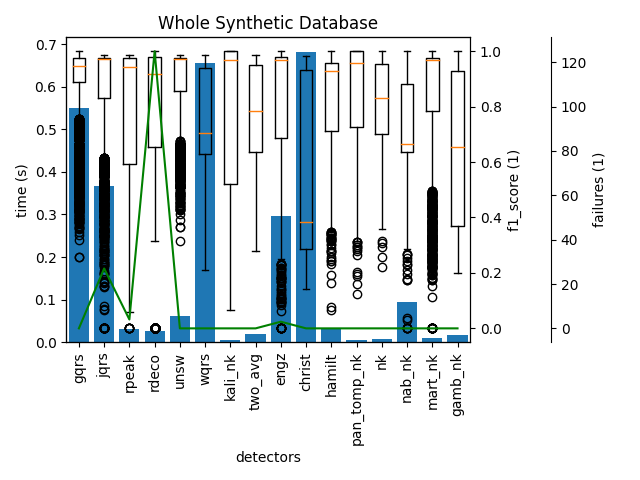

In [132]:
detectors = [Evaluation.Detector for Evaluation in synth_whole_database.Users[0].Recordings[0].Evaluations]
users = synth_whole_database.Users

print('Database: ',synth_whole_database.Name)

runtime = [[[] for user in range(len(users))] for detector in range(len(detectors))]
sensitivity = [[[] for user in range(len(users))] for detector in range(len(detectors))]
positive_predictivity = [[[] for user in range(len(users))] for detector in range(len(detectors))]
f1_score = [[[] for user in range(len(users))] for detector in range(len(detectors))]
failed = [0 for detector in range(len(detectors))]
SNR_ms = [[] for user in range(len(users))]
SNR_dB = [[] for user in range(len(users))]

for j in range(len(users)):
    for recording in users[j].Recordings:
        SNR_ms[j].append(np.mean(recording.WholeSignal)/(np.std(recording.WholeSignal)))
        SNR_dB[j].append(20*np.log10((np.max(recording.WholeSignal)-np.min(recording.WholeSignal))/(2*recording.AdditionalInfo["noiseRMS"] if recording.AdditionalInfo["noiseRMS"] != 0 else 0.001)))
        evaluations = recording.Evaluations
        for i in range(len(evaluations)):
            runtime[i][j].append(evaluations[i].runtime)
            sensitivity[i][j].append(evaluations[i].sensitivity)
            positive_predictivity[i][j].append(evaluations[i].positive_predictivity)
            f1_score[i][j].append(evaluations[i].f1_score)
            if evaluations[i].failed:
                failed[i] = failed[i] + 1

data = [np.around([np.mean(np.mean(time)) for time in runtime],decimals=2),np.around([np.min(np.min(sens)) for sens in sensitivity],decimals=2), np.around([np.min(np.min(pos_pred)) for pos_pred in positive_predictivity],decimals=2),np.around([np.min(np.min(f1)) for f1 in f1_score],decimals=2)]
rows = ["runtime (s)","sensitiv", "pos pred", "f1 score"]
columns = [detector.short_name for detector in detectors]

print(pandas.DataFrame(data, rows, columns))

f1_score_print = [[] for f1 in f1_score]
for i in range(len(f1_score)):
    for j in range(len(f1_score[i])):
        for f1 in f1_score[i][j]:
            f1_score_print[i].append(f1)

fig, ax = plt.subplots()
ax.bar(range(1, len(runtime)+1),[np.mean(np.mean(time)) for time in runtime])
ax.set_ylabel("time (s)")
ax.set_title(synth_whole_database.Name) 
ax.set_xlabel("detectors")

ax2 = ax.twinx()
ax2.boxplot(f1_score_print)
ax2.set_ylabel("f1_score (1)")

ax3 = ax.twinx()
ax3.plot(range(1, len(detectors)+1),failed, "g-")
ax3.set_ylabel("failures (1)")
ax3.spines.right.set_position(("axes", 1.2))


ax.set_xticks(range(1, len(detectors)+1))
ax.set_xticklabels(columns, rotation = 'vertical')

plt.tight_layout()

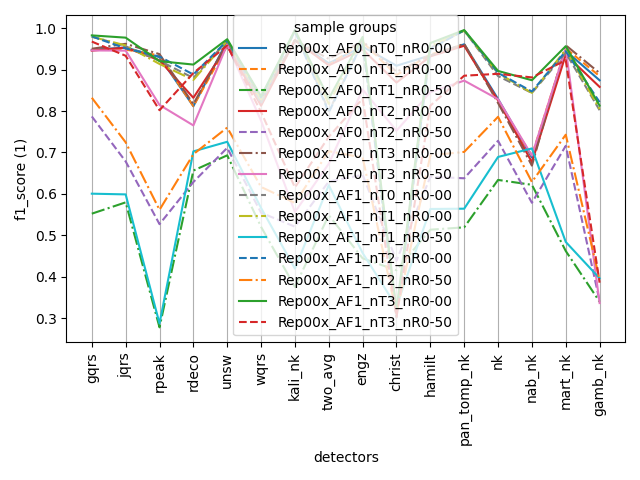

In [95]:
f1_score_transpose = np.array(f1_score).transpose(1, 0, 2)
f1_score_transpose = np.mean(f1_score_transpose, axis=2)
user_names = [user.UserName for user in synth_whole_database.Users]
detector_names = [detector.short_name for detector in detectors]
lines = ["-","--","-."]#,":"]
linecycler = cycle(lines)

fig, ax = plt.subplots()
for f1 in f1_score_transpose:
    ax.plot(range(1,len(detectors)+1),f1,next(linecycler))
ax.set_xticks(range(1,len(detectors)+1))
ax.set_xticklabels(detector_names, rotation = 'vertical')
ax.legend(user_names,title="sample groups")
ax.xaxis.grid(True)
ax.set_xlabel("detectors")
ax.set_ylabel("f1_score (1)")
plt.tight_layout()
pass

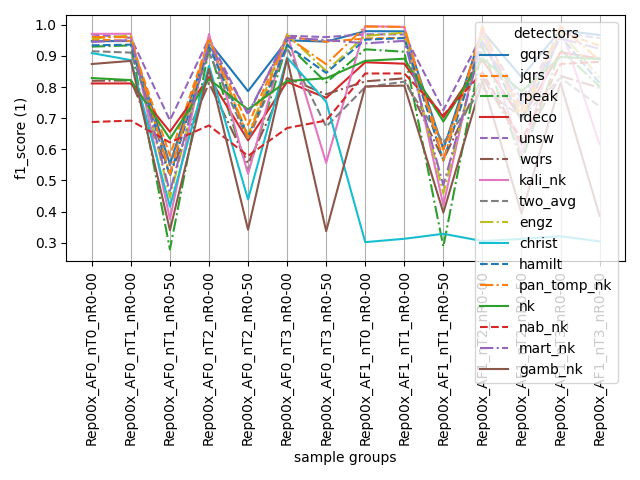

In [96]:
f1_score_mean = np.mean(f1_score, axis=2)
user_names = [user.UserName for user in synth_whole_database.Users]
detector_names = [detector.short_name for detector in detectors]
lines = ["-","--","-."]#,":"]
linecycler = cycle(lines)

fig, ax = plt.subplots()
for f1 in f1_score_mean:
    ax.plot(range(1, len(synth_whole_database.Users)+1),f1,next(linecycler))
ax.set_xticks(range(1, len(synth_whole_database.Users)+1))
ax.set_xticklabels(user_names, rotation = 'vertical')
ax.legend(detector_names, title="detectors")
ax.xaxis.grid(True)
ax.set_xlabel("sample groups")
ax.set_ylabel("f1_score (1)")
plt.tight_layout()
pass

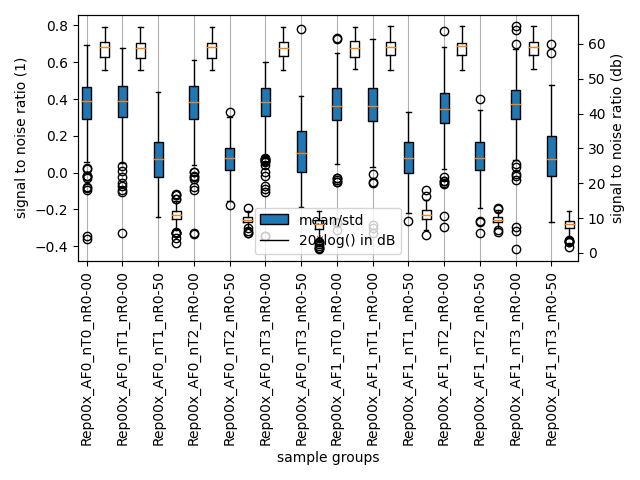

In [133]:
user_names = [user.UserName for user in synth_whole_database.Users]

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.boxplot(SNR_ms,vert=True, patch_artist=True, positions=range(1, 2*len(synth_whole_database.Users)+1,2))
ax2.boxplot(SNR_dB, positions=range(2, 2*len(synth_whole_database.Users)+1,2))
ax.set_xticks(range(1, 2*len(synth_whole_database.Users)+1,2))
ax.set_xticklabels(user_names, rotation = 'vertical')
ax.legend(["mean/std","20*log() in dB"])
ax.xaxis.grid(True)
ax.set_xlabel("sample groups")
ax.set_ylabel("signal to noise ratio (1)")
ax2.set_ylabel("signal to noise ratio (db)")
plt.tight_layout()
pass

# Test

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

data = []
for feature in features:
    feature = np.array(feature)
    x = feature[:,0:4]
    y = feature[:,4]
    model = LinearRegression()
    model.fit(StandardScaler().fit_transform(x),y)
    data.append(model.coef_)

fig, ax = plt.subplots()
ax.plot(data,label=['ip_APBrate','ip_AFburden','ip_noiseType','ip_noiseRMS'])
ax.legend()

In [ ]:
from sklearn.preprocessing import StandardScaler


feature = np.array(features[1])

x = feature[:,0:4]
y = feature[:,4]




In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(StandardScaler().fit_transform(x),y)
print(model.coef_)


In [ ]:
x_new = x - np.mean(x)
x_new = x_new / np.std(x_new)
#x_new = StandardScaler().fit_transform(x)
covariance = np.cov(x_new.T)
w, v = np.linalg.eigh(covariance)
print(covariance)
print(w)
print(v)

In [ ]:
x = StandardScaler().fit_transform(x)

In [ ]:
print(x)
print(y)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

principalDf = pandas.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pandas.concat([principalDf, pandas.DataFrame(data=y,columns=['target'])], axis = 1)


In [ ]:
pca.get_feature_names_out(input_features=['a', 'b', 'c', 'd'])
pca.get_covariance()

In [ ]:
pca.explained_variance_ratio_

In [ ]:
print(finalDf)

In [ ]:
plt.figure()
plt.scatter(x=principalComponents[:,0], y=principalComponents[:,1],cmap=plt.cm.hot_r, c=y)
plt.colorbar()